In [ ]:
import random
from tqdm import tqdm
from transformers import LlamaForCausalLM, AutoTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from peft import PeftModel
import pickle

/raid/speech/harshavardhan/miniconda3/envs/llama-icll/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torch
dev = torch.device('cuda:4')

random.seed(42)
torch.random.manual_seed(42)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("model/llama3")
model = LlamaForCausalLM.from_pretrained("model/llama3")
model.to(dev)
model.eval()

cmap = sns.color_palette("Blues", as_cmap=True)

dataset = 'monotonic-cfg'
original_X = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
num_evals = 10
num_seq=16
X = original_X
length_X = 8
seq_length = 4

In [2]:
def attention_scores(attention, layer, mask):
    '''
    This function calculates the attention scores (alignment accuracy and IC lookup accuracy) for a given layer
    '''
    attention = torch.mean(attention[layer][0], dim=0).detach().cpu().numpy()

    total_alignment_acc = 0
    total_ic_lookup_acc = 0

    example_length = (seq_length*len(X) + len(X))*2+1
    
    for i in range(num_seq-1, num_seq):
        for j in range(len(X)):
            for k in range(1):
                pos = example_length*(i) + len(X)*2+1 + j*seq_length*2 + 2*k

                token_attention = attention[pos][example_length*(i):pos]
                temp_mask = mask[example_length*(i):pos]

                alignment_acc = (np.argmax(token_attention * (temp_mask == -mask[pos+1])) == np.argmax(token_attention * (temp_mask != 0)))
                total_alignment_acc += alignment_acc

    for i in range(num_seq-1, num_seq):
        for j in range(len(X)):
            for k in range(seq_length):
                pos = example_length*(i) + len(X)*2+1 + j*seq_length*2 + 2*k

                token_attention = attention[pos][:example_length*(num_seq-1)]
                temp_mask = mask[:example_length*(num_seq-1)]

                ic_lookup_acc = np.sum(token_attention * (temp_mask == mask[pos+1])) / np.sum(token_attention * (temp_mask > 0))
                total_ic_lookup_acc += ic_lookup_acc

    total_alignment_acc /= len(X)
    total_ic_lookup_acc /= (len(X)*4)

    return total_alignment_acc, total_ic_lookup_acc

    

In [3]:
def mask_for_token_inputs(tokens):
    '''
    This function generates a mask for the token inputs. The mask is a list of integers with the same length as the tokens.
    The mask is used to highlight the tokens in the input sequence. The mask is generated by assigning a unique integer to x token.
    '''
    m = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8}
    
    mask = np.zeros(len(tokens))

    example_length = (seq_length*len(X) + len(X))*2+1

    for i in range(num_seq):
        for j in range(len(X)):
            for k in range(seq_length):
                mask[example_length*i + len(X)*2+1 + j*seq_length*2 + 2*k+1] = m[tokens[example_length*i + 2*j+1]]

    for i in range(len(tokens)):
        if tokens[i] in m.keys():
            mask[i] = -m[tokens[i]]

    return mask

In [4]:
checkpoints = range(0, 210, 10)

layers = range(32)

alignment_accs = {layer: [0]*len(checkpoints) for layer in layers}
attention_accs = {layer: [0]*len(checkpoints) for layer in layers}

with torch.no_grad():
    for index, checkpoint in tqdm(enumerate(checkpoints)):
        
        for idx, example in enumerate(open(f'data/{dataset}/val.txt', 'r').readlines()):
            
            model_inputs = tokenizer(example.strip(), return_tensors="pt")["input_ids"].to(dev)
            tokens = tokenizer.convert_ids_to_tokens(model_inputs[0])

            mask = mask_for_token_inputs(tokens)

            if checkpoint == 0:
                output = model.forward(model_inputs, output_attentions=True)
            else:
                finetuned_model = PeftModel.from_pretrained(model, f"model/llama3_finetuned/monotonic-cfg-32-0/checkpoint-{checkpoint}")
                finetuned_model.eval()
                finetuned_model.to(dev)

                output = finetuned_model.forward(model_inputs, output_attentions=True)

            for layer in layers:
                alignment_acc, attention_acc = attention_scores(output.attentions, layer, mask)
                alignment_accs[layer][index] += alignment_acc
                attention_accs[layer][index] += attention_acc

for layer in layers:
    for i in range(len(checkpoints)):
        alignment_accs[layer][i] /= num_evals
        attention_accs[layer][i] /= num_evals

0it [00:00, ?it/s]LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
21it [06:41, 19.12s/it]


In [6]:
pickle.dump(alignment_accs, open(f'dump/alignment_accs.pkl', 'wb'))
pickle.dump(attention_accs, open(f'dump/attention_accs.pkl', 'wb'))

In [3]:
alignment_accs = pickle.load(open(f'dump/alignment_accs.pkl', 'rb'))
attention_accs = pickle.load(open(f'dump/attention_accs.pkl', 'rb'))

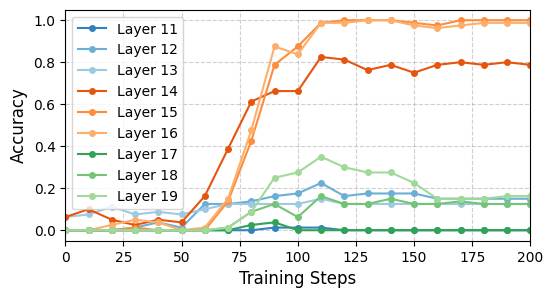

<Figure size 640x480 with 0 Axes>

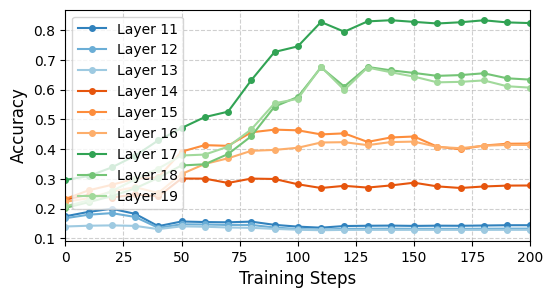

In [4]:
colors = sns.color_palette('tab20c')

checkpoints = range(0, 210, 10)

displayed_layers = [11, 12, 13, 14, 15, 16, 17, 18, 19]
displayed_color = [0, 1, 2, 4, 5, 6, 8, 9, 10]

fig, ax = plt.subplots(figsize=(6, 3))

# Plot Alignment Accuracy
for i, layer in enumerate(displayed_layers):
    plt.plot(checkpoints, alignment_accs[layer-1], label=f'Layer {layer}', marker='o', markersize=4, color=colors[displayed_color[i]])

plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel("Training Steps", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xlim(0, 200)
plt.legend(loc='upper left', fontsize=10)
plt.show()
# plt.savefig('figures/alignment_accuracy_final.png', dpi=300, bbox_inches='tight')

plt.clf()

fig, ax = plt.subplots(figsize=(6, 3))

# Plot IC-Lookup Accuracy
for i, layer in enumerate(displayed_layers):
    plt.plot(checkpoints, attention_accs[layer-1], label=f'Layer {layer}', marker='o', markersize=4, color=colors[displayed_color[i]])

plt.xlim(0, 200)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel("Training Steps", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.show()
# plt.savefig('figures/ic_lookup_accuracy_final.png', dpi=300, bbox_inches='tight')